In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import random
#import cv2
import os

In [3]:
# Check filenames 
image_names=list(os.listdir("Database"))
image_names.sort()
print(image_names)

['.DS_Store', 'COVID19', 'NORMAL', 'Viral_Pneumonia']


In [4]:
covid_dir=os.path.join("Database/COVID19")
norm_dir=os.path.join("Database/NORMAL")
pneu_dir=os.path.join("Database/Viral_Pneumonia")


print('total Covid images:', len(os.listdir(covid_dir)))
print('total Normal images:', len(os.listdir(norm_dir)))
print('total Viral_Pneumonia:', len(os.listdir(pneu_dir)))


total Covid images: 1327
total Normal images: 1341
total Viral_Pneumonia: 1463


In [5]:
df =pd.DataFrame(os.listdir(covid_dir))
df["condition"]= "Covid19"
df.head()

,0,condition
0,COVID-19 (979).png,Covid19
1,COVID-19 (580).png,Covid19
2,COVID-19 (996).png,Covid19
3,COVID-19 (646).png,Covid19
4,COVID-19 (216).png,Covid19


In [6]:
df =pd.DataFrame.from_records({"file_name":os.listdir(covid_dir),"condition": "Covid19"})

for f in image_names[1:]:
    folder_path="Database/" + f
    temp_df= pd.DataFrame.from_records({"file_name":os.listdir(folder_path),"condition": f })
    df=df.append(temp_df)
    
df["condition"].value_counts()

Viral_Pneumonia    1463
NORMAL             1341
Covid19            1327
COVID19            1327
Name: condition, dtype: int64

In [7]:
img_width, img_height=200,200
batch_size=128

data_dir = "Database/"

# Rescale images 
datagen= ImageDataGenerator(rescale=1/255,validation_split=.3,rotation_range=20,
                           shear_range=.2,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2)

# Flow training images in batches of 128 using train_data 
train_generator= datagen.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                subset="training",
                class_mode="categorical", 
                classes= ["COVID19", "NORMAL","Viral_Pneumonia"],
                shuffle=True, seed=30)


datagen2=ImageDataGenerator(rescale=1/255,validation_split=.3)

test_generator=datagen2.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                classes= ["COVID19", "NORMAL","Viral_Pneumonia"],
                class_mode="categorical", subset="validation", shuffle=True, seed=30)

# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

# # Flow test images in 


# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

Found 2893 images belonging to 3 classes.
Found 1238 images belonging to 3 classes.


## Model 1
### Using new dataset and with 3 categories

In [8]:
# CNN MODEL- conv-batch-maxpool-dropout

classifier=Sequential()
classifier.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(200,200,3)))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(strides=(2,2)))
classifier.add(Dropout(.3))

classifier.add(Conv2D(32, kernel_size=3, activation="relu"))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(strides=(2,2)))
classifier.add(Dropout(.5))

classifier.add(Conv2D(64, kernel_size=3, activation="relu"))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(strides=(2,2)))
classifier.add(Dropout(.4))

classifier.add(Conv2D(64, kernel_size=3, activation="relu"))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(strides=(2,2)))
classifier.add(Dropout(.3))

classifier.add(Flatten())
classifier.add(Dense(512,activation="relu"))
classifier.add(Dense(128,activation="relu"))
classifier.add(Dropout(.4))

classifier.add(Dense(3, activation="softmax"))

In [9]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 198, 198, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 97, 97, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0

In [10]:
classifier.compile(loss="categorical_crossentropy", 
              optimizer="adam", 
              metrics=["categorical_accuracy"])

total_sample=train_generator.n
total_test=test_generator.n
batch_size=128

history= classifier.fit_generator(
            train_generator, steps_per_epoch=int(total_sample/batch_size),
            epochs=30,
            validation_data=test_generator, 
            validation_steps=int(total_test/batch_size))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
22/22 [==============================] - 109s 5s/step - loss: 1.4534 - categorical_accuracy: 0.5899 - val_loss: 2.6489 - val_categorical_accuracy: 0.5521
Epoch 2/30
22/22 [==============================] - 102s 5s/step - loss: 0.5664 - categorical_accuracy: 0.7801 - val_loss: 5.3865 - val_categorical_accuracy: 0.3177
Epoch 3/30
22/22 [==============================] - 99s 5s/step - loss: 0.4596 - categorical_accuracy: 0.8213 - val_loss: 8.3850 - val_categorical_accuracy: 0.3220
Epoch 4/30
22/22 [==============================] - 97s 4s/step - loss: 0.4332 - categorical_accuracy: 0.8394 - val_loss: 4.6281 - val_categorical_accuracy: 0.4462
Epoch 5/30
22/22 [==============================] - 105s 5s/step - loss: 0.3562 - categorical_accuracy: 0.8694 - val_loss: 6.7347 - val_categorical_accuracy: 0.3125
Epoch 6/30
22/22 [==============================] - 98s 4s/step - loss: 0.3449 - categorical_accuracy

In [11]:
# Save Model- save weights
classifier.save("model_1.h5")

In [12]:
# Train Loss/ Train Accuracy
train_loss, train_acc = classifier.evaluate(train_generator)
print("\n Train Accuracy:", train_acc)
print("\n Train Loss:", train_loss)

23/23 [==============================] - 56s 2s/step - loss: 2.9574 - categorical_accuracy: 0.5973

 Train Accuracy: 0.5973038077354431

 Train Loss: 2.957383632659912


In [13]:
# Test Loss/ Test Accuracy
test_loss, test_acc= classifier.evaluate(test_generator)
print("\n Test Accuracy:", test_acc)
print("\n Test Loss:", test_loss)

10/10 [==============================] - 15s 1s/step - loss: 1.6552 - categorical_accuracy: 0.6632

 Test Accuracy: 0.6631664037704468

 Test Loss: 1.6551761627197266


In [19]:
classifier.metrics_names

['loss', 'categorical_accuracy']

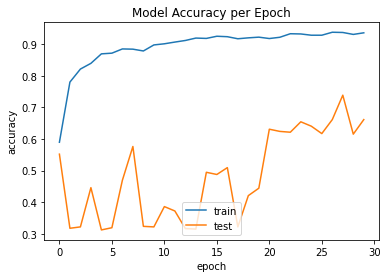

In [20]:
# PLOT ACCURACY
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower center')
plt.show()

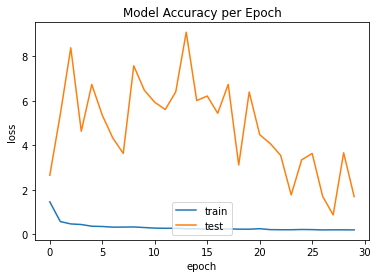

In [25]:
# PLOT LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower center')
plt.show()

In [30]:
# Save history of model into csv
hist_df1 = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history1.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df1.to_csv(f)

## Model 2

In [31]:
## Model 2
classifier= Sequential()

# First convolution layer
classifier.add(Conv2D(32, (3,3), input_shape=(200,200,3),activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Second convolution layer
classifier.add(Conv2D(64,(3,3),activation="relu"))
classifier.add(Dropout(0.1))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Third convolution layer
classifier.add(Conv2D(64, (3,3), activation="relu"))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Fourth convolution layer
classifier.add(Conv2D(128, (3,3), activation="relu"))
classifier.add(Dropout(0.2))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))

#Fifth convolution layer
classifier.add(Conv2D(128, (3,3), activation="relu"))
classifier.add(Dropout(0.2))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the results to feed into a dense layer
classifier.add(Flatten())

# 128 neuron in the fully-connected layer
classifier.add(Dense(units = 128 , activation = 'relu'))
classifier.add(Dropout(0.2))

# 14 output neurons for 14 classes with the softmax activation
classifier.add(Dense(units = 3 , activation = 'softmax'))

In [32]:
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 198, 198, 32)      128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 97, 97, 64)        18496     
_________________________________________________________________
dropout_13 (Dropout)         (None, 97, 97, 64)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 97, 97, 64)        256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 48, 48, 64)       

In [33]:
# Model 2, with augmentation
classifier.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])


total_sample= train_generator.n
total_test=test_generator.n
batch_size=128


history= classifier.fit_generator(
            train_generator, steps_per_epoch=int(total_sample/batch_size),
            epochs=30,
            validation_data=test_generator,
            validation_steps=int(total_test/batch_size))

Epoch 1/30
22/22 [==============================] - 113s 5s/step - loss: 0.7904 - accuracy: 0.7353 - val_loss: 1.5889 - val_accuracy: 0.3186
Epoch 2/30
22/22 [==============================] - 121s 6s/step - loss: 0.3502 - accuracy: 0.8687 - val_loss: 2.8283 - val_accuracy: 0.5703
Epoch 3/30
22/22 [==============================] - 109s 5s/step - loss: 0.2948 - accuracy: 0.8911 - val_loss: 3.5147 - val_accuracy: 0.4983
Epoch 4/30
22/22 [==============================] - 110s 5s/step - loss: 0.2565 - accuracy: 0.9087 - val_loss: 4.4834 - val_accuracy: 0.3229
Epoch 5/30
22/22 [==============================] - 108s 5s/step - loss: 0.2481 - accuracy: 0.9107 - val_loss: 5.0507 - val_accuracy: 0.3229
Epoch 6/30
22/22 [==============================] - 109s 5s/step - loss: 0.2424 - accuracy: 0.9161 - val_loss: 4.6095 - val_accuracy: 0.3264
Epoch 7/30
22/22 [==============================] - 126s 6s/step - loss: 0.2216 - accuracy: 0.9233 - val_loss: 4.6092 - val_accuracy: 0.3368
Epoch 8/30
22

In [34]:
# Save Model-save weights
classifier.save("model_2.h5")

In [35]:
# Train loss/ Train Accuracy
train_loss, train_acc = classifier.evaluate(train_generator)
print("\n Train Accuracy:", train_acc)
print("\n Train Loss:", train_loss)

23/23 [==============================] - 59s 3s/step - loss: 3.5160 - accuracy: 0.5900

 Train Accuracy: 0.5900449156761169

 Train Loss: 3.515977144241333


In [36]:
# Test Loss/ Test Accuracy
test_loss, test_acc= classifier.evaluate(test_generator)
print("\n Test Accuracy:", test_acc)
print("\n Test Loss:", test_loss)

10/10 [==============================] - 16s 2s/step - loss: 2.5968 - accuracy: 0.6195

 Test Accuracy: 0.6195476651191711

 Test Loss: 2.5968239307403564


In [39]:
classifier.metrics_names

['loss', 'accuracy']

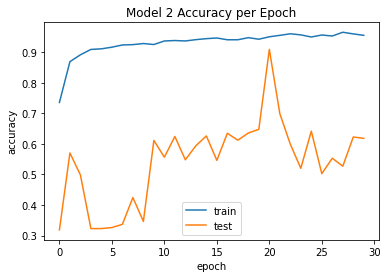

In [40]:
# PLOT ACCURACY
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model 2 Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower center')
plt.show()

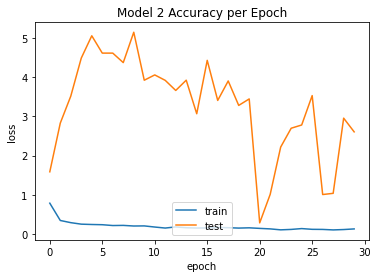

In [41]:
# PLOT LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model 2 Accuracy per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower center')
plt.show()

In [38]:
# Save history of model into csv
hist_df2 = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history2.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df2.to_csv(f)

# Model 3

In [42]:
# Model 3
# GENERATE MODEL
classifier= Sequential()

# First convolution layer
classifier.add(Conv2D(32, (3,3), input_shape=(200,200,3),activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Second convolution layer
classifier.add(Conv2D(32,(3,3),activation="relu"))
classifier.add(Dropout(0.1))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the results to feed into a dense layer
classifier.add(Flatten())

# 128 neuron in the fully-connected layer
classifier.add(Dense(128 , activation = 'relu'))
classifier.add(Dropout(0.2))

# 14 output neurons for 14 classes with the softmax activation
classifier.add(Dense(3 , activation = 'softmax'))

In [44]:
classifier.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
batch_normalization_19 (Batc (None, 198, 198, 32)      128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 97, 97, 32)        9248      
_________________________________________________________________
dropout_17 (Dropout)         (None, 97, 97, 32)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 97, 97, 32)        128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 48, 48, 32)       

In [45]:
# Model 3, with augmentation
classifier.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])

# total_valsample=test_generator.n
total_sample= train_generator.n
total_test=test_generator.n
batch_size=128

history= classifier.fit_generator(
            train_generator, steps_per_epoch=int(total_sample/batch_size),
            epochs=30,
            validation_data=test_generator,
            validation_steps=int(total_test/batch_size))

Epoch 1/30
22/22 [==============================] - 97s 4s/step - loss: 1.7917 - accuracy: 0.6307 - val_loss: 2.0458 - val_accuracy: 0.5972
Epoch 2/30
22/22 [==============================] - 95s 4s/step - loss: 1.1467 - accuracy: 0.7638 - val_loss: 1.0402 - val_accuracy: 0.6068
Epoch 3/30
22/22 [==============================] - 89s 4s/step - loss: 0.6806 - accuracy: 0.7917 - val_loss: 1.7709 - val_accuracy: 0.5903
Epoch 4/30
22/22 [==============================] - 89s 4s/step - loss: 0.5549 - accuracy: 0.8242 - val_loss: 5.2704 - val_accuracy: 0.5764
Epoch 5/30
22/22 [==============================] - 89s 4s/step - loss: 0.5075 - accuracy: 0.8257 - val_loss: 8.2677 - val_accuracy: 0.6120
Epoch 6/30
22/22 [==============================] - 91s 4s/step - loss: 0.4065 - accuracy: 0.8448 - val_loss: 9.3292 - val_accuracy: 0.5694
Epoch 7/30
22/22 [==============================] - 89s 4s/step - loss: 0.4379 - accuracy: 0.8488 - val_loss: 10.8449 - val_accuracy: 0.5139
Epoch 8/30
22/22 [=

In [46]:
# Save Model-save weights
classifier.save("model_3.h5")

In [47]:
# Train loss/ Train Accuracy
train_loss, train_acc = classifier.evaluate(train_generator)
print("\n Train Accuracy:", train_acc)
print("\n Train Loss:", train_loss)

23/23 [==============================] - 56s 2s/step - loss: 0.8944 - accuracy: 0.7598

 Train Accuracy: 0.7597649693489075

 Train Loss: 0.894377589225769


In [48]:
# Test Loss/ Test Accuracy
test_loss, test_acc= classifier.evaluate(test_generator)
print("\n Test Accuracy:", test_acc)
print("\n Test Loss:", test_loss)

10/10 [==============================] - 14s 1s/step - loss: 0.9478 - accuracy: 0.6882

 Test Accuracy: 0.6882067918777466

 Test Loss: 0.9478113651275635


In [49]:
classifier.metrics_names

['loss', 'accuracy']

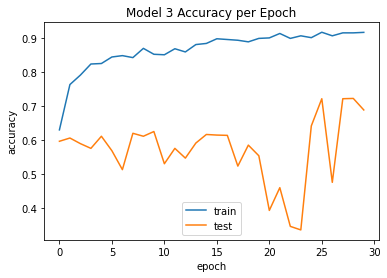

In [50]:
# PLOT ACCURACY
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model 3 Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower center')
plt.show()

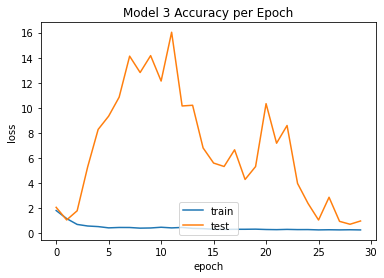

In [51]:
# PLOT LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model 3 Accuracy per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower center')
plt.show()

In [52]:
# Save history of model into csv
hist_df3 = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history3.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df3.to_csv(f)

# Model 4- Transfer Learning

In [53]:
img_width, img_height=200,200
batch_size=128

data_dir = "Database/"

# Rescale images 
datagen= ImageDataGenerator(rescale=1/255,validation_split=.3,rotation_range=20,
                           shear_range=.2,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2,
                           preprocessing_function=preprocess_input)

# Flow training images in batches of 128 using train_data 
train_generator= datagen.flow_from_directory(
                data_dir,
                target_size=(64,64),
                batch_size=batch_size,
                subset="training",
                class_mode="categorical", 
                classes= ["COVID19", "NORMAL","Viral_Pneumonia"],
                shuffle=True, seed=30)


datagen2=ImageDataGenerator(rescale=1/255,validation_split=.3,
                            preprocessing_function=preprocess_input)

test_generator=datagen2.flow_from_directory(
                data_dir,
                target_size=(64,64),
                batch_size=batch_size,
                classes= ["COVID19", "NORMAL","Viral_Pneumonia"],
                class_mode="categorical", subset="validation", shuffle=True, seed=30)

Found 2893 images belonging to 3 classes.
Found 1238 images belonging to 3 classes.


In [54]:
# Model 4

datagen= ImageDataGenerator(rescale=1/255,validation_split=.3)

classifier=VGG16(weights="imagenet", include_top=False, input_shape=(64,64,3))

for layer in classifier.layers:
    layer.trainable=False

x=Flatten()(classifier.output)
x=Dense(3, activation="softmax")(x)

model=Model(inputs=classifier.input, outputs=x)
model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy"])

In [56]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)      

In [55]:
total_sample= train_generator.n
batch_size=128


history= model.fit_generator(
            train_generator, steps_per_epoch=int(total_sample/batch_size),
            epochs=100,
            validation_data=test_generator)

Epoch 1/100
22/22 [==============================] - 71s 3s/step - loss: 0.9659 - accuracy: 0.5392 - val_loss: 0.7505 - val_accuracy: 0.6236
Epoch 2/100
 1/22 [>.............................] - ETA: 0s - loss: 0.7554 - accuracy: 0.6953

KeyboardInterrupt: 

In [ ]:
# Save Model-save weights
classifier.save("model_4tf_vgg16.h5")

In [ ]:
# Train loss/ Train Accuracy
train_loss, train_acc = model.evaluate(train_generator)
print("\n Train Accuracy:", train_acc)
print("\n Train Loss:", train_loss)

In [ ]:
# Test Loss/ Test Accuracy
test_loss, test_acc= model.evaluate(test_generator)
print("\n Test Accuracy:", test_acc)
print("\n Test Loss:", test_loss)

In [ ]:
model.metrics_names

In [ ]:
# PLOT ACCURACY
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model 3 Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower center')
plt.show()

In [ ]:
# PLOT LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model 3 Accuracy per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower center')
plt.show()

## Model 4 at 100 epochs, from before...

In [12]:
# Model 4- Transfer Learning
data_dir = "Database/"

# Rescale images 
datagen= ImageDataGenerator(rescale=1/255,validation_split=.3,rotation_range=20,
                           shear_range=.2,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2,
                           preprocessing_function=preprocess_input)

# Flow training images in batches of 128 using train_data 
train_generator= datagen.flow_from_directory(
                data_dir,
                target_size=(64,64),
                batch_size=batch_size,
                subset="training",
                class_mode="categorical", 
                classes= ["COVID19", "NORMAL","Viral_Pneumonia"],
                shuffle=True, seed=30)


datagen2=ImageDataGenerator(rescale=1/255,validation_split=.3,
                            preprocessing_function=preprocess_input)

test_generator=datagen2.flow_from_directory(
                data_dir,
                target_size=(64,64),
                batch_size=batch_size,
                classes= ["COVID19", "NORMAL","Viral_Pneumonia"],
                class_mode="categorical", subset="validation", shuffle=True, seed=30)

Found 2893 images belonging to 3 classes.
Found 1238 images belonging to 3 classes.


In [13]:
datagen= ImageDataGenerator(rescale=1/255,validation_split=.3)

classifier=VGG16(weights="imagenet", include_top=False, input_shape=(64,64,3))

for layer in classifier.layers:
    layer.trainable=False

x=Flatten()(classifier.output)
x=Dense(3, activation="softmax")(x)

model=Model(inputs=classifier.input, outputs=x)
model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy"])

In [14]:
total_sample= train_generator.n
batch_size=128


history= model.fit_generator(
            train_generator, steps_per_epoch=int(total_sample/batch_size),
            epochs=100,
            validation_data=test_generator)

Epoch 1/100
22/22 [==============================] - 67s 3s/step - loss: 0.8128 - accuracy: 0.7052 - val_loss: 0.6017 - val_accuracy: 0.8069
Epoch 2/100
22/22 [==============================] - 66s 3s/step - loss: 0.5718 - accuracy: 0.8145 - val_loss: 0.5529 - val_accuracy: 0.7504
Epoch 3/100
22/22 [==============================] - 65s 3s/step - loss: 0.4830 - accuracy: 0.8427 - val_loss: 0.4969 - val_accuracy: 0.7763
Epoch 4/100
22/22 [==============================] - 66s 3s/step - loss: 0.4414 - accuracy: 0.8495 - val_loss: 0.4655 - val_accuracy: 0.7989
Epoch 5/100
22/22 [==============================] - 64s 3s/step - loss: 0.4107 - accuracy: 0.8582 - val_loss: 0.5311 - val_accuracy: 0.7447
Epoch 6/100
22/22 [==============================] - 67s 3s/step - loss: 0.3899 - accuracy: 0.8752 - val_loss: 0.4976 - val_accuracy: 0.7738
Epoch 7/100
22/22 [==============================] - 66s 3s/step - loss: 0.3798 - accuracy: 0.8676 - val_loss: 0.4605 - val_accuracy: 0.7981
Epoch 8/100
2

## Model 5-Transfer Learning

In [15]:
# Model 5- Transfer Learning
data_dir = "Database/"

# Rescale images 
datagen= ImageDataGenerator(rescale=1/255,validation_split=.3,rotation_range=20,
                           shear_range=.2,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2,
                           preprocessing_function=preprocess_input)

# Flow training images in batches of 128 using train_data 
train_generator= datagen.flow_from_directory(
                data_dir,
                target_size=(64,64),
                batch_size=batch_size,
                subset="training",
                class_mode="categorical", 
                classes= ["COVID19", "NORMAL","Viral_Pneumonia"],
                shuffle=True, seed=30)


datagen2=ImageDataGenerator(rescale=1/255,validation_split=.3,
                            preprocessing_function=preprocess_input)

test_generator=datagen2.flow_from_directory(
                data_dir,
                target_size=(64,64),
                batch_size=batch_size,
                classes= ["COVID19", "NORMAL","Viral_Pneumonia"],
                class_mode="categorical", subset="validation", shuffle=True, seed=30)

Found 2893 images belonging to 3 classes.
Found 1238 images belonging to 3 classes.


In [18]:
datagen= ImageDataGenerator(rescale=1/255,validation_split=.3)

# classifier=VGG16(weights="imagenet", include_top=False, input_shape=(64,64,3))


# x=Flatten()(classifier.output)
# x=Dense(3, activation="softmax")(x)


classifier = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(64, 64, 3)))

x = classifier.output
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Flatten(name="flatten")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.6)(x)
x = Dense(3, activation="softmax")(x)

for layer in classifier.layers:
    layer.trainable=False

model=Model(inputs=classifier.input, outputs=x)
model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy"])

In [19]:
total_sample= train_generator.n
batch_size=128


history= model.fit_generator(
            train_generator, steps_per_epoch=int(total_sample/batch_size),
            epochs=50,
            validation_data=test_generator)

Epoch 1/50
22/22 [==============================] - 66s 3s/step - loss: 0.9848 - accuracy: 0.5288 - val_loss: 0.6371 - val_accuracy: 0.7876
Epoch 2/50
22/22 [==============================] - 66s 3s/step - loss: 0.6620 - accuracy: 0.7320 - val_loss: 0.5263 - val_accuracy: 0.7617
Epoch 3/50
22/22 [==============================] - 66s 3s/step - loss: 0.5388 - accuracy: 0.8000 - val_loss: 0.4934 - val_accuracy: 0.7746
Epoch 4/50
22/22 [==============================] - 65s 3s/step - loss: 0.5017 - accuracy: 0.8134 - val_loss: 0.5262 - val_accuracy: 0.7391
Epoch 5/50
22/22 [==============================] - 65s 3s/step - loss: 0.4776 - accuracy: 0.8206 - val_loss: 0.5202 - val_accuracy: 0.7447
Epoch 6/50
22/22 [==============================] - 66s 3s/step - loss: 0.4473 - accuracy: 0.8260 - val_loss: 0.5485 - val_accuracy: 0.7278
Epoch 7/50
22/22 [==============================] - 66s 3s/step - loss: 0.4282 - accuracy: 0.8383 - val_loss: 0.4510 - val_accuracy: 0.7940
Epoch 8/50
22/22 [==